In [1]:
import requests
import datetime
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

figsize = (15, 3)

## Data prep

In [2]:
query_url = 'https://data.ca.gov/api/3/action/datastore_search?resource_id=926fd08f-cc91-4828-af38-bd45de97f8c3&limit=100000'
response = requests.get(query_url)

if response.status_code == 200:
    print('Successfully ran API query')
else:
    print('Unexpected response code', response.status_code)

Successfully ran API query


In [3]:
county_df = pd.DataFrame(response.json()['result']['records']).set_index('_id')

county_df.head()

,totalcountconfirmed,newcountdeaths,totalcountdeaths,county,newcountconfirmed,date
_id,,,,,,
1,151.0,6,6.0,Santa Clara,151,2020-03-18T00:00:00
2,183.0,2,8.0,Santa Clara,32,2020-03-19T00:00:00
3,246.0,0,8.0,Santa Clara,63,2020-03-20T00:00:00
4,269.0,2,10.0,Santa Clara,23,2020-03-21T00:00:00
5,284.0,3,13.0,Santa Clara,15,2020-03-22T00:00:00


In [4]:
county_df.describe(include='all')

,totalcountconfirmed,newcountdeaths,totalcountdeaths,county,newcountconfirmed,date
count,17642.000000,17645.000000,17643.000000,17645,17645.000000,17645
unique,NaN,NaN,NaN,60,NaN,295
top,NaN,NaN,NaN,Humboldt,NaN,2020-10-27T00:00:00
freq,NaN,NaN,NaN,295,NaN,60
mean,10689.397064,1.589402,182.931531,NaN,142.737943,NaN
std,40442.925102,7.860393,739.624164,NaN,701.848882,NaN
min,0.000000,-16.000000,0.000000,NaN,-3419.000000,NaN
25%,58.000000,0.000000,1.000000,NaN,0.000000,NaN
50%,743.500000,0.000000,11.000000,NaN,11.000000,NaN
75%,6739.000000,0.000000,93.000000,NaN,74.000000,NaN


In [5]:
# Check for missing values
if len(county_df[county_df.isna().any(axis=1)]) > 0:
    print("Missing values:")
    display(county_df[county_df.isna().any(axis=1)])

Missing values:


,totalcountconfirmed,newcountdeaths,totalcountdeaths,county,newcountconfirmed,date
_id,,,,,,
1192,NaN,0,NaN,Sierra,0,2020-03-29T00:00:00
8849,NaN,0,NaN,Lake,0,2020-03-29T00:00:00
10966,NaN,0,0.0,Out Of Country,0,2020-07-01T00:00:00


In [6]:
county_df.fillna(value=0, inplace=True)

In [7]:
# check for duplicates
num_rows_before = len(county_df)
county_df.drop_duplicates(subset=['date', 'county'], inplace=True)
assert len(county_df) == num_rows_before, "Found duplicate rows"

In [8]:
# add all counties together to get state-wide stats
# then re-create columns to match San Diego data formatting
df = pd.DataFrame(data=county_df.groupby('date')[['totalcountconfirmed', 'newcountdeaths', 'totalcountdeaths']].sum()).sort_index()
df.columns = ['total_cases_reported', 'deaths_today', 'deaths']

df['reported_new_cases'] = df.total_cases_reported - df.total_cases_reported.shift()
df['reported_new_cases'].fillna(value=0, inplace=True)

df['date_str'] = df.index.astype('datetime64[ns]').to_series().dt.strftime('%m/%d')

df.head()

,total_cases_reported,deaths_today,deaths,reported_new_cases,date_str
date,,,,,
2020-03-18T00:00:00,675.0,15,15.0,0.0,03/18
2020-03-19T00:00:00,1006.0,3,18.0,331.0,03/19
2020-03-20T00:00:00,1224.0,4,22.0,218.0,03/20
2020-03-21T00:00:00,1468.0,4,26.0,244.0,03/21
2020-03-22T00:00:00,1733.0,9,35.0,265.0,03/22


In [9]:
# can check against today's numbers on the news
df.tail()

,total_cases_reported,deaths_today,deaths,reported_new_cases,date_str
date,,,,,
2021-01-02T00:00:00,2391261.0,181,26538.0,45352.0,01/02
2021-01-03T00:00:00,2420894.0,97,26635.0,29633.0,01/03
2021-01-04T00:00:00,2452334.0,368,27003.0,31440.0,01/04
2021-01-05T00:00:00,2482226.0,459,27462.0,29892.0,01/05
2021-01-06T00:00:00,2518611.0,583,28045.0,36385.0,01/06


In [10]:
# testing data is in another table, so we have to make another API call then join to the existing data
tests_query_url = 'https://data.ca.gov/api/3/action/datastore_search?resource_id=b6648a0d-ff0a-4111-b80b-febda2ac9e09&limit=100000'
response = requests.get(tests_query_url)

if response.status_code == 200:
    print('Successfully ran API query')
    
    tests_df = pd.DataFrame(response.json()['result']['records']).set_index('date').drop(labels='_id', axis=1)
    display(tests_df.head())
else:
    print('Unexpected response code', response.status_code)

Successfully ran API query


,tested
date,
2020-03-18T00:00:00,6291
2020-03-19T00:00:00,11487
2020-03-20T00:00:00,12528
2020-03-21T00:00:00,13467
2020-03-22T00:00:00,14317


In [11]:
# join to existing data 
df = df.merge(right=tests_df, left_index=True, right_index=True)

# format like San Diego data
df.columns = ['total_cases_reported', 'deaths_today', 'deaths', 'reported_new_cases', 'date_str', 'tests']
df['newtests'] = df['tests'] - df['tests'].shift()
df['newtests'].fillna(0, inplace=True)

df.head()

,total_cases_reported,deaths_today,deaths,reported_new_cases,date_str,tests,newtests
date,,,,,,,
2020-03-18T00:00:00,675.0,15,15.0,0.0,03/18,6291,0.0
2020-03-19T00:00:00,1006.0,3,18.0,331.0,03/19,11487,5196.0
2020-03-20T00:00:00,1224.0,4,22.0,218.0,03/20,12528,1041.0
2020-03-21T00:00:00,1468.0,4,26.0,244.0,03/21,13467,939.0
2020-03-22T00:00:00,1733.0,9,35.0,265.0,03/22,14317,850.0


## Visualizations

In [12]:
def plot_by_time(col):
    df.set_index('date_str')[col].plot.bar(figsize=figsize, rot=50)
    [label.set_visible(False) for label in plt.gca().get_xticklabels() if label.get_text()[3:] != '01']
    plt.xlabel('Date')

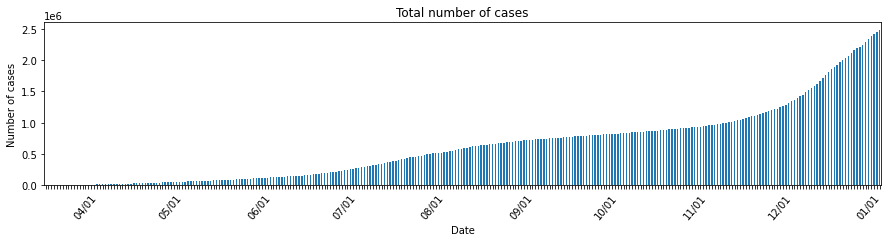

In [13]:
plot_by_time(col='total_cases_reported')
plt.title('Total number of cases')
plt.ylabel('Number of cases');

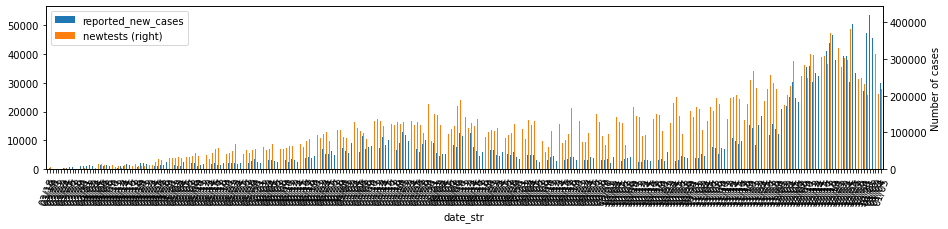

In [14]:
df.set_index('date_str')[['reported_new_cases', 'newtests']].plot.bar(figsize=figsize, secondary_y= 'newtests', rot=70)
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.show();

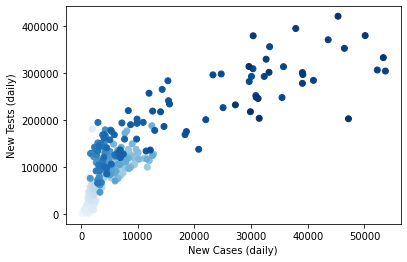

In [15]:
plt.scatter(df['reported_new_cases'].values, df['newtests'].values, c=range(len(df)), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('New Cases (daily)');

In [16]:
stats.spearmanr(df['reported_new_cases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.840666458338969, pvalue=9.265293807086631e-80)

## Estimate current actual cases by number of deaths
As explained by Tomas Pueyo in his [brilliant Medium article](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca) and later by [Salman Khan himself](https://www.youtube.com/watch?v=mCa0JXEwDEk), we can calculate an estimate for the actual number of cases using a roundabout method based on more accurately reported numbers.

The first thing we need is the doubling time. That is, the number of days until the number of cases doubles from what it is currently. In Khan's example, he only calculated the value once, but we want to calculate it for many days. It's reasonable to think that it will change since it depends on all kinds of things like public policy and how many people are adhering to social distancing guidelines, and these things change significantly as public opinion changes. 

For one pair of days we can use a formula from the [Doubling Time wiki page](https://en.wikipedia.org/wiki/Doubling_time).

In [17]:
# test out our formula - we should get a doubling rate of 1 day
q1 = 100
q2 = 200
time_delta = 1 # days

time_delta * np.log(2) / np.log(q2/q1)

1.0

Notice that this will change based on how many days apart we sample the two days. Let's take a look at our doubling rate for different sampling spacings.

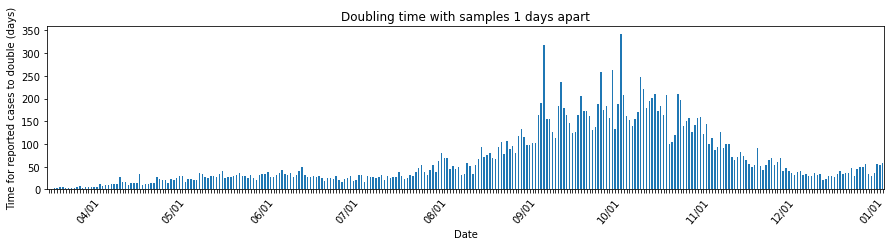

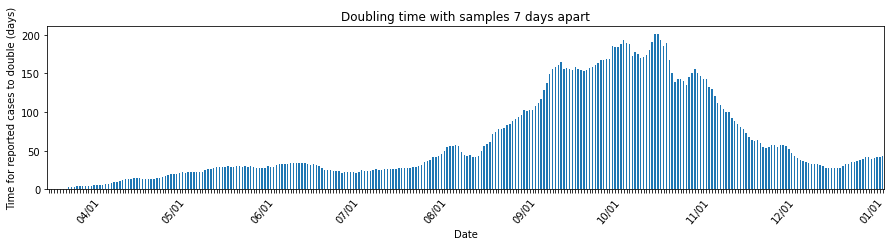

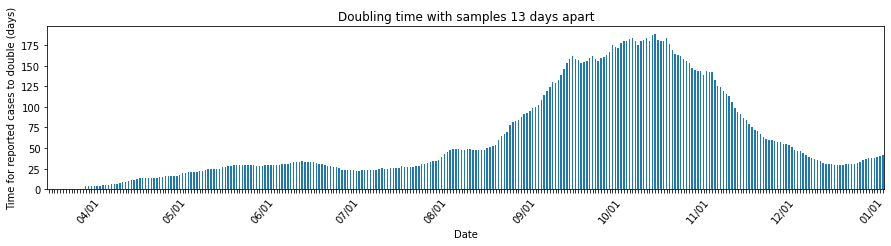

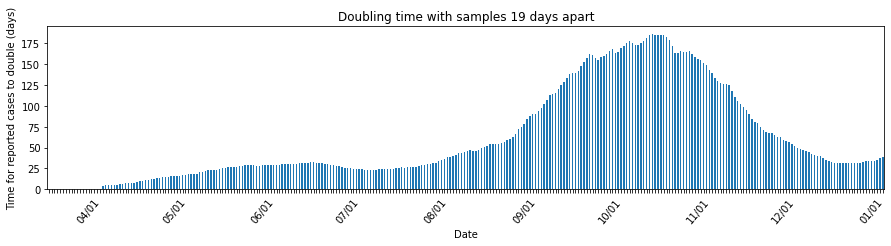

In [18]:
for i in range(1, 20, 6):
    time_delta = i # days
    df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df['total_cases_reported'], dtype=float) / 
                                                           np.array(df.shift(periods=time_delta)['total_cases_reported'], dtype=float))
    
    plt.figure()
    plt.title(f'Doubling time with samples {i} days apart')
    plot_by_time('days_to_double')
    plt.ylabel('Time for reported cases to double (days)')
    plt.xlabel('Date');

Increasing the time between samples for calculating doubling rate smooths out the noise of individual days, but also pushes back the earliest time we can make an inference about. I've chosen a time of 7 days so we have a smoother curve without sacrificing very much of the earlier data.  
Today's doubling time (May 21) is fairly close to the County's reported time of 34 days.

In [19]:
time_delta = 7 # days
df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df['total_cases_reported'], dtype=float) / 
                                                       np.array(df.shift(periods=time_delta)['total_cases_reported'], dtype=float))

So now that we have the doubling rate for each day, we can make some assumptions for the remaining pieces needed.

In [20]:
mortality_rate = 0.01 # 1%
infection_to_death_time = 20 # days

In [21]:
# example for May 21, 2020
total_deaths = 242
doubling_time_days = 34

estimated_cases_20_days_ago = total_deaths / mortality_rate
number_of_times_doubled = infection_to_death_time / doubling_time_days
cases_estimate_by_deaths = np.exp2(number_of_times_doubled) * estimated_cases_20_days_ago

print(f'If there were {total_deaths} deaths up until now, then that would mean there were {int(estimated_cases_20_days_ago)} cases 20 days ago.\n' + 
      f'Since then the number of cases would have doubled {number_of_times_doubled:3.3f} times, so there would be {int(cases_estimate_by_deaths)} total cases today.')

If there were 242 deaths up until now, then that would mean there were 24200 cases 20 days ago.
Since then the number of cases would have doubled 0.588 times, so there would be 36382 total cases today.


In [22]:
df['estimated_total_cases'] = df.apply(lambda row:
                                       np.exp2(infection_to_death_time / row['days_to_double']) * 
                                       row['deaths'] / mortality_rate
                                       ,axis=1)

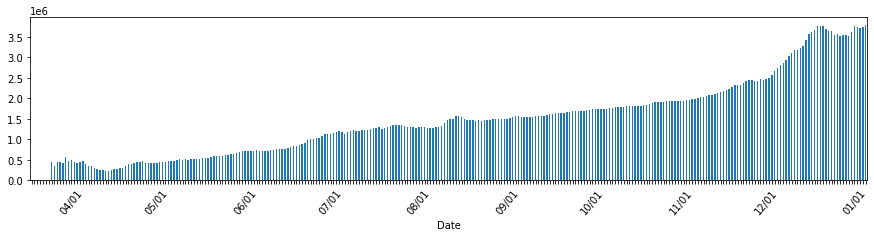

In [23]:
plot_by_time('estimated_total_cases')

In [24]:
df['times_doubled_since_ttd'] = infection_to_death_time / df['days_to_double']

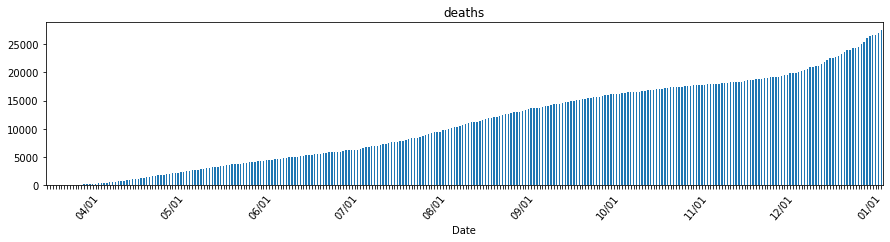

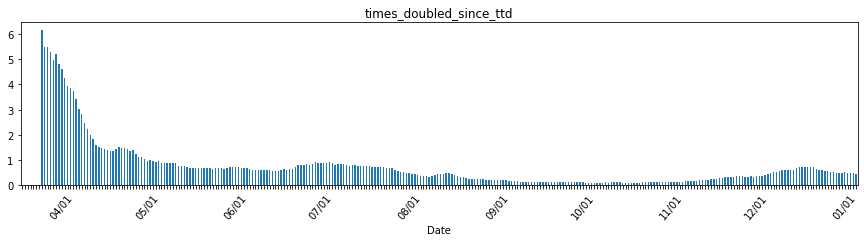

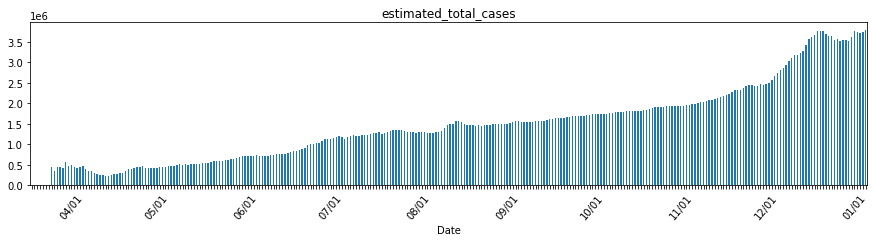

In [25]:
for col in ['deaths', 'times_doubled_since_ttd', 'estimated_total_cases']:
    plt.figure()
    plot_by_time(col)
    plt.title(col)

In [26]:
df.estimated_total_cases.fillna(0, inplace=True)
df['estimated_new_cases'] = df['estimated_total_cases'] - df.shift(periods=1)['estimated_total_cases']

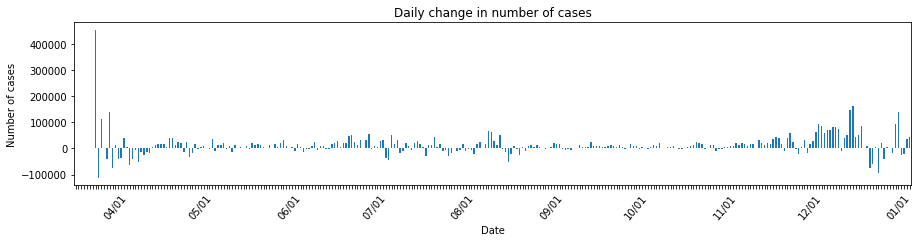

In [27]:
plot_by_time('estimated_new_cases')
plt.title('Daily change in number of cases')
plt.ylabel('Number of cases');

And now let's see how our estimate compares to just the reported cases:

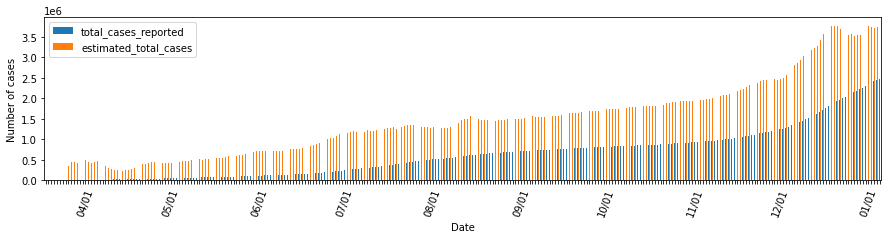

In [28]:
ax = df.set_index('date_str')[['total_cases_reported', 'estimated_total_cases']].plot.bar(figsize=figsize, rot=70)
for label in ax.get_xticklabels():
    if label.get_text()[3:] != '01':
        label.set_visible(False)
plt.ylabel('Number of cases')
plt.xlabel('Date');

And, finally, did we fix the issue of our cases being dependent on test rate?

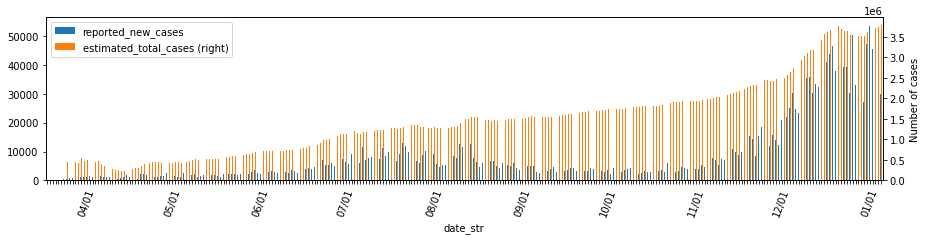

In [29]:
ax = df.set_index('date_str')[['reported_new_cases', 'estimated_total_cases']].plot.bar(figsize=figsize, secondary_y= 'estimated_total_cases', rot=70)
for label in ax.get_xticklabels():
    if label.get_text()[3:] != '01':
        label.set_visible(False)
plt.ylabel('Number of cases')
plt.xlabel('Date');

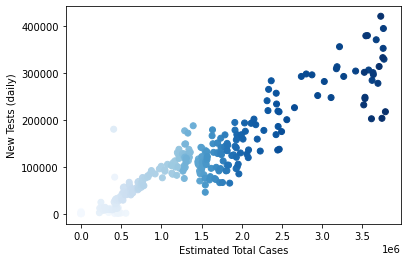

In [30]:
plt.scatter(df['estimated_total_cases'].values, df['newtests'].values, c=range(len(df)), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('Estimated Total Cases');

In [31]:
df['has_estimate'] = df['estimated_new_cases'].notnull()

In [32]:
stats.spearmanr(df[df['has_estimate']]['estimated_new_cases'].values, 
                df[df['has_estimate']]['newtests'].values)

SpearmanrResult(correlation=0.19426669813930517, pvalue=0.0008287785132827589)

In [33]:
stats.spearmanr(df['reported_new_cases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.840666458338969, pvalue=9.265293807086631e-80)

In [34]:
df['positive_estimate_change'] = df['estimated_new_cases'] > 0

In [35]:
stats.spearmanr(df[df['positive_estimate_change']]['estimated_new_cases'].values, 
                df[df['positive_estimate_change']]['newtests'].values)

SpearmanrResult(correlation=0.21783803534375612, pvalue=0.00157326859376675)

In [36]:
stats.spearmanr(df['reported_new_cases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.840666458338969, pvalue=9.265293807086631e-80)

In [37]:
stats.spearmanr(df['total_cases_reported'].values, df['newtests'].values)

SpearmanrResult(correlation=0.8909648987147355, pvalue=3.972866500345518e-102)

In [38]:
stats.spearmanr(df[df['has_estimate']]['estimated_total_cases'].values, 
                df[df['has_estimate']]['newtests'].values)

SpearmanrResult(correlation=0.8901007615004848, pvalue=2.5886968305095122e-101)